In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.optim as optim
import cellpylib as cpl
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import sys
from matplotlib import pyplot as plt

In [5]:
sys.path.append("C:/Users/windows/Research/CA_Project")
from block_entropy import get_block_entropy_feature_matrix, get_block_entropy_feature_vector, block_entropy, mutual_information_feature_vector

In [6]:
def create_ca(ca_size, t_steps, rule_number, ic=None):
    if ic is None:
        ic = cpl.init_random(ca_size)
    ca = cpl.evolve(ic, timesteps=t_steps+3, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number), memoize=True)

    # remove tranients
    ca = ca[3:]

    return ca

In [7]:
def get_window_2d(ca_state, size, pos):
    # Get the dimensions of the CA state
    rows, cols = ca_state.shape

    # Calculate the starting and ending indices for the rows
    start_row = (pos[0] - size // 2) % rows
    end_row = (pos[0] + size // 2 + 1) % rows

    # Calculate the starting and ending indices for the columns
    start_col = (pos[1] - size // 2) % cols
    end_col = (pos[1] + size // 2 + 1) % cols

    # Slice the CA state
    if start_row <= end_row:
        window_rows = ca_state[start_row:end_row, :]
    else:
        window_rows = np.vstack((ca_state[start_row:, :], ca_state[:end_row, :]))

    if start_col <= end_col:
        window = window_rows[:, start_col:end_col]
    else:
        window = np.hstack((window_rows[:, start_col:], window_rows[:, :end_col]))

    window = np.array(window).flatten()
    return window

In [14]:
def get_block_entropy_feature_matrix(ca_state, window_size):
    rows = len(ca_state)
    columns = len(ca_state[0])
    entropy_feature_matrix = np.zeros((rows, columns))
    for y in range(rows):
        for x in range(columns):
            window = get_window_2d(ca_state, window_size, (x, y))
            entropy_feature_matrix[x][y] = cpl.shannon_entropy(window.tolist())

    max = np.max(entropy_feature_matrix)
    min = np.min(entropy_feature_matrix)

    entropy_feature_matrix_normalized = (entropy_feature_matrix - min) / (max - min)

    return entropy_feature_matrix

In [9]:
def get_ones_density_map(ca_spacetime, window_size, L):
    rows = len(ca_spacetime)
    columns = len(ca_spacetime[0])
    density_feature_map = np.zeros((rows, columns))
    # entropy_feature_matrix = np.zeros((rows, columns))
    for y in range(rows):
        for x in range(columns):
            window = get_window_2d(ca_spacetime, window_size, (x, y))
            n_ones = 0
            for i in window:
                if i == 1:
                    n_ones += 1
            density_feature_map[x][y] = n_ones
            # entropy_feature_matrix[x][y] = block_entropy(window, L)
            
    return density_feature_map

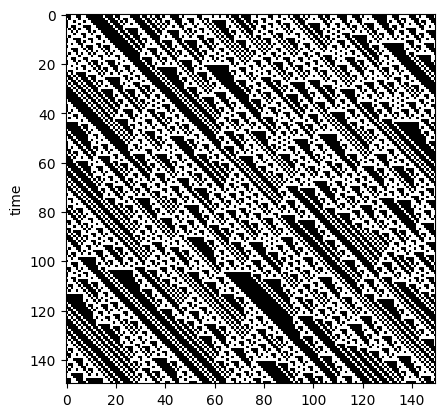

In [20]:
spacetime = create_ca(ca_size=150, t_steps=150, rule_number=225)
cpl.plot(spacetime)

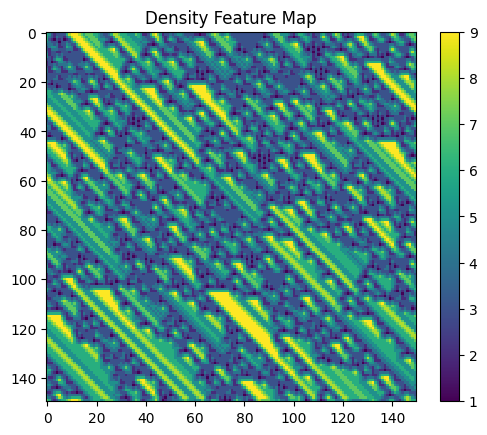

In [21]:
density_map = get_ones_density_map(spacetime, 3, 1)

plt.imshow(density_map, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to indicate the values
plt.title("Density Feature Map")
plt.show()

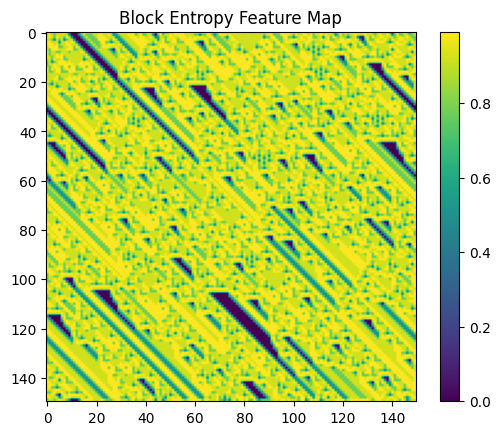

In [22]:
H_map = get_block_entropy_feature_matrix(spacetime, window_size=3)
plt.imshow(H_map, cmap='viridis')
plt.colorbar()  # Add a colorbar to indicate the values
plt.title("Block Entropy Feature Map")
plt.show()

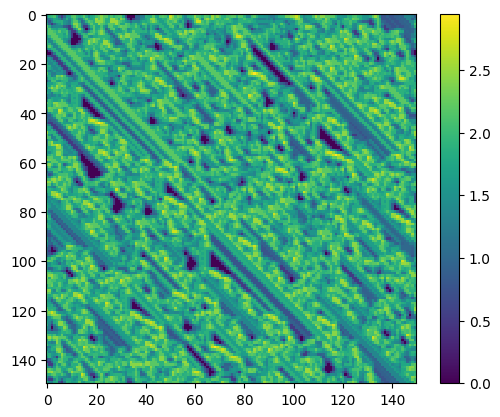

In [25]:
H_on_density_map = get_block_entropy_feature_matrix(density_map, 3)
plt.imshow(H_on_density_map, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to indicate the values
#plt.title("Heatmap of Ones Density Feature Map")
plt.show()

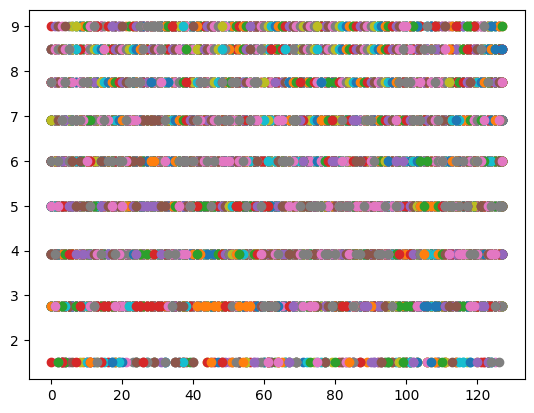

In [121]:
fig, ax = plt.subplots()

for t in density_map:
    ax.plot(np.arange(128), t, marker='o', linestyle='None')


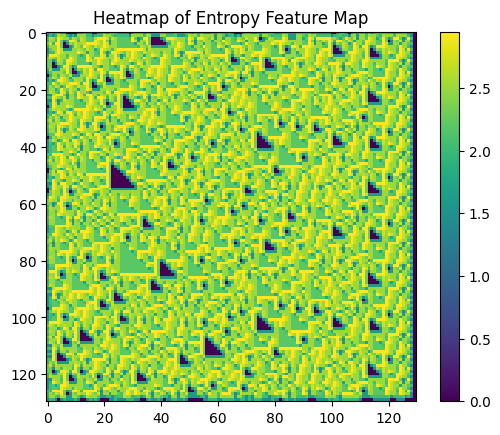

In [73]:
H_map = get_block_entropy_feature_matrix(ca_state=image, window_size=3, L=3)

plt.imshow(H_map, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to indicate the values
plt.title("Heatmap of Entropy Feature Map")
plt.show()

In [ ]:
def generate_1D_spacetime_feature_maps(num_samples, rule_number, ca_size, H_window_size, I_window_size, L):
    
    # Initialize dataset array
    input_data = np.zeros((num_samples, 2, ca_size, ca_size))  
    output_data = np.zeros((num_samples, 1, ca_size, ca_size))
    
    ics = np.zeros((num_samples, ca_size, ca_size))
    for n in range(num_samples):
        
        print(f"generating sample {n}...")
        
        ic = cpl.init_random(ca_size)
        
        spacetime = cpl.evolve(ic, timesteps=ca_size+1, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number), memoize=True)
        for t in range(ca_size):
            
            state = spacetime[t+1]
            prev_state = spacetime[t]

            # get entropy feature map
            H = get_block_entropy_feature_vector(state, H_window_size, L)

            # get mutual information feature map
            I = mutual_information_feature_vector(state, prev_state, I_window_size)
    
        
            input_data[n][0][t] = H
            input_data[n][1][t] = I

        output_data[n][0] = spacetime[1:]
             
    input_data = torch.from_numpy(input_data).to(torch.float32)
    output_data = torch.from_numpy(output_data).to(torch.float32)
        
    return input_data, output_data